# Final Setup for Automating Code Reviews

> 3-Component agent

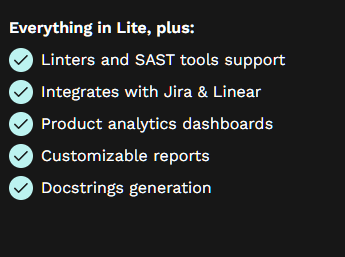

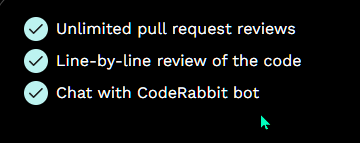

## Tasks


### Schema

In [ ]:
-- Drops all tables

DROP TABLE tasks CASCADE;


-- Creates

CREATE TABLE tasks (
    id SERIAL PRIMARY KEY,
    task_name TEXT NOT NULL,
    task_content TEXT NOT NULL,
    task_instructions TEXT NOT NULL,
    model_answer_1 TEXT NOT NULL,
    model_answer_2 TEXT NOT NULL,
    metadata JSONB
);

CREATE TABLE reviews (
    id SERIAL PRIMARY KEY,
    task_id INT NOT NULL,
    task_name TEXT NOT NULL,
    review_content TEXT NOT NULL,
    submitted_content_1 TEXT NOT NULL,
    submitted_content_2 TEXT NOT NULL,
    metadata JSONB,
    FOREIGN KEY (task_id) REFERENCES tasks (id) ON DELETE CASCADE
);


## Vectorisers


### Task Vectorisers

In [ ]:
SELECT ai.create_vectorizer(   
    'tasks'::regclass,
    formatting => ai.formatting_python_template('$chunk'),
    embedding => ai.embedding_ollama('nomic-embed-text', 768),
    chunking => ai.chunking_recursive_character_text_splitter('task_content'),
    destination => 'task_contents_embedding'
);

SELECT ai.create_vectorizer(   
    'tasks'::regclass,
    formatting => ai.formatting_python_template('$chunk'),
    embedding => ai.embedding_ollama('nomic-embed-text', 768),
    chunking => ai.chunking_recursive_character_text_splitter('task_instructions'),
    destination => 'task_instructions_embedding'
);

SELECT ai.create_vectorizer(   
    'tasks'::regclass,
    formatting => ai.formatting_python_template('$chunk'),
    embedding => ai.embedding_ollama('codellama:13b-instruct', 5120),
    chunking => ai.chunking_recursive_character_text_splitter('model_answer_1', 
        chunk_size => 1024, 
        chunk_overlap => 256
    ),
    destination => 'task_model_answer_1_embedding'
);

SELECT ai.create_vectorizer(   
    'tasks'::regclass,
    formatting => ai.formatting_python_template('$chunk'),
    embedding => ai.embedding_ollama('codellama:13b-instruct', 5120),
    chunking => ai.chunking_recursive_character_text_splitter('model_answer_2', 
        chunk_size => 1024, 
        chunk_overlap => 256
    ),
    destination => 'task_model_answer_2_embedding'
);

-- Vectoriser status
SELECT * FROM ai.vectorizer_status;


### Review Vectorisers

In [ ]:
SELECT ai.create_vectorizer(   
    'reviews'::regclass,
    formatting => ai.formatting_python_template('$chunk'),
    embedding => ai.embedding_ollama('nomic-embed-text', 768),
    chunking => ai.chunking_recursive_character_text_splitter('review_content', 
        chunk_size => 512, 
        chunk_overlap => 256
    ),
    destination => 'review_contents_embedding'
);

SELECT ai.create_vectorizer(   
    'reviews'::regclass,
    formatting => ai.formatting_python_template('$chunk'),
    embedding => ai.embedding_ollama('codellama:13b-instruct', 5120),
    chunking => ai.chunking_recursive_character_text_splitter('submitted_content_1'),
    destination => 'submitted_content_1_embedding'
);

SELECT ai.create_vectorizer(   
    'reviews'::regclass,
    formatting => ai.formatting_python_template('$chunk'),
    embedding => ai.embedding_ollama('codellama:13b-instruct', 5120),
    chunking => ai.chunking_recursive_character_text_splitter('submitted_content_2'),
    destination => 'submitted_content_2_embedding'
);

SELECT * FROM ai.vectorizer_status;


In [ ]:
-- Vectoriser execute
SELECT ai.execute_vectorizer(125);

-- Vectoriser status
select * from ai.vectorizer_status;


## RAG Functions

## Basic - Code Review Generation

In [ ]:
CREATE OR REPLACE FUNCTION basic_generate_review(query_code_1 TEXT, query_code_2 TEXT, task_title TEXT, file_name TEXT)
RETURNS TEXT AS $$
DECLARE
  context_chunks TEXT;
  response TEXT;
BEGIN
  WITH relevant_info AS (
    (SELECT 
      'Task Contexts' AS source,
      t1.task_name,
      t1.chunk, t2.chunk
      FROM task_contents_embedding t1
      INNER JOIN task_instructions_embedding t2
      ON t1.task_name = t2.task_name
      ORDER BY t1.embedding <=> ai.ollama_embed('nomic-embed-text', task_title)
      LIMIT 1
    )
    (SELECT
      'Model Answer Contexts' AS source,
      t1.task_name,
      t1.chunk, t2.chunk
      FROM task_model_answer_1_embedding t1
      INNER JOIN task_model_answer_2_embedding t2
      ON t1.task_name = t2.task_name
      ORDER BY t1.embedding <=> ai.ollama_embed('codellama:13b-instruct', query_code_1)
      LIMIT 1
    )
    (SELECT 
      'Review Context' AS source,
      chunk
      FROM review_contents_embedding
      ORDER BY embedding <=> ai.ollama_embed('nomic-embed-text', task_title)
      LIMIT 1
    )
    (SELECT
      'Submission Answer Contexts' AS source,
      t1.task_name,
      t1.chunk, t2.chunk
      FROM submitted_content_1_embedding t1
      INNER JOIN submitted_content_2_embedding t2
      ON t1.task_name = t2.task_name
      ORDER BY t2.embedding <=> ai.ollama_embed('codellama:13b-instruct', query_code_1 || E'\n\n' || query_code_2)
      LIMIT 1
    )
  )
  SELECT string_agg(source || ': ' || chunk, E'\n') INTO context_chunks
  FROM relevant_info;

  SELECT ai.ollama_chat_complete(
    'llama3',
    jsonb_build_array(
      jsonb_build_object(
        'role', 'system', 
        'content', 'You are an expert code reviewer. Your task is to review the given code (query_text) and ensure it matches the task instructions. Provide a detailed review, highlighting strengths, areas for improvement, and any discrepancies between the code and the task requirements.'
      ),
      jsonb_build_object(
        'role', 'user',
        'content', 'Task Name: ' || task_title || E'\n\n' ||
        'File name:\n' || file_name || E'\n\n' ||
        'Code to review:\n' || query_text_1 || query_text_2 || E'\n\n' ||
        'Use the following context for your review:\n' || context_chunks || E'\n\n' ||
        'Please provide a comprehensive code review, focusing on how well the code matches the task instructions. Include specific suggestions for improvement if necessary.'
      )
    )
  )->'message'->>'content' INTO response;

  RETURN response;
END;
$$ LANGUAGE plpgsql;

## Advanced - Code Review Generation


In [ ]:
CREATE OR REPLACE FUNCTION generate_code_review(query_code TEXT, task_title TEXT)
RETURNS TEXT AS $$
DECLARE
    context_chunks TEXT;
    response TEXT;
BEGIN
    WITH relevant_info AS (
        -- Task Context and Instructions (lower weight)
        (SELECT 
            t1.task_name,
            '===== Task: ' || t1.task_name || ' =====' || E'\n'
            || 'Task Context:\n' || t1.chunk || E'\n'
            || 'Instructions:\n' || t2.chunk AS chunk,
            (t1.embedding <=> ai.ollama_embed('nomic-embed-text', task_title)) * 0.8 AS relevance_score
        FROM task_contents_embedding t1
        INNER JOIN task_instructions_embedding t2
        ON t1.task_name = t2.task_name
        LIMIT 2
        )

        UNION ALL

        -- Model Answer Context (lower weight)
        (SELECT
            t1.task_name,
            '===== Model Answer =====' || E'\n' || t1.chunk AS chunk,
            (t1.embedding <=> ai.ollama_embed('codellama:13b-instruct', query_code)) * 0.6 AS relevance_score
        FROM task_model_answer_1_embedding t1
        LIMIT 1
        )

        UNION ALL

        -- Review Context (medium weight)
        (SELECT 
            '' AS task_name,
            '===== Review Guidelines =====' || E'\n' || chunk AS chunk,
            (embedding <=> ai.ollama_embed('nomic-embed-text', task_title)) * 1.0 AS relevance_score
        FROM review_contents_embedding
        LIMIT 1
        )
    )
    SELECT string_agg(chunk, E'\n\n' ORDER BY relevance_score DESC)
    INTO context_chunks
    FROM (
        SELECT chunk, relevance_score
        FROM relevant_info
        ORDER BY relevance_score DESC
        LIMIT 5  -- Adjust this limit based on your needs
    ) AS top_chunks;

    -- Validate the context_chunks to ensure it's not empty
    IF context_chunks IS NULL OR context_chunks = '' THEN
        RAISE EXCEPTION 'No relevant context found for the provided query_code and task_title.';
    END IF;

    -- Generate the review using the combined context
    SELECT ai.ollama_chat_complete(
        'llama3',
        jsonb_build_array(
            jsonb_build_object(
                'role', 'system',
                'content', 'You are Branden, an expert code reviewer. Provide a detailed, actionable review of the given code, focusing on its quality, efficiency, and alignment with the task objectives. Be specific in your analysis and suggestions.'
            ),
            jsonb_build_object(
                'role', 'user',
                'content',
                'Task Title: ' || task_title || E'\n\n' ||
                'Code to Review:\n' || query_code || E'\n\n' ||
                'Context:\n' || context_chunks || E'\n\n' ||
                'Review Instructions:\n' ||
                '1. Efficiency: Rate and provide a detailed explanation.\n' ||
                '2. Completeness: Rate and check against all task objectives.\n' ||
                '3. Style: Rate and reference specific style guidelines.\n' ||
                '4. Documentation: Rate and suggest improvements.\n' ||
                'For each category, provide:\n' ||
                '1. Specific examples from the code\n' ||
                '2. Detailed suggestions for improvement\n' ||
                '3. References to best practices or task objectives\n' ||
                'Structure your review as follows:\n' ||
                'Positive:\n' ||
                'Highlight specific strengths, referencing code snippets and task objectives.\n\n' ||
                'Improve:\n' ||
                'Provide actionable feedback with code examples. Address any misalignments with task objectives.\n\n' ||
                'Overall:\n' ||
                'Summarize the code''s quality and alignment with task objectives. Provide a holistic evaluation.\n\n' ||
                'Ensure all feedback is specific, actionable, and tied directly to the provided code and task objectives.\n' ||
                'Include code snippets for all suggestions and highlight both good practices and areas for improvement.\n\n' ||
                'Explicitly address any discrepancies between the submission and task requirements.\n'
            )
        ),
        host => 'http://ollama:11434'
    ) -> 'message' ->> 'content' INTO response;
    RETURN response;

END;
$$ LANGUAGE plpgsql;

## Basic - General Interaction

### Content

In [ ]:
-- Function is used to generate BASIC responses 
-- Context is `task content` and `task instructions` as context

CREATE FUNCTION basic_general_response(query_text TEXT)
RETURNS TEXT AS $$ -- Return type

-- Global variables
DECLARE
    context_chunks TEXT;
    response TEXT;

BEGIN
    -- Get `task content` data
    WITH relevant_task_content AS (
        SELECT task_name, chunk
        FROM task_contents_embedding
        ORDER BY embedding <=> ai.ollama_embed('nomic-embed-text', query_text)
    ),

    -- Get `task instruction` data
    relevant_task_instructions AS
    (
        SELECT task_name, chunk
        FROM task_instructions_embedding
        ORDER BY embedding <=> ai.ollama_embed('nomic-embed-text', query_text)
    )

    -- Collect and pass `relevant data` to `context chunks`
    SELECT string_agg(chunk, E'\n') 
    INTO context_chunks
    FROM (
        SELECT * FROM relevant_task_content
        UNION ALL
        SELECT * FROM relevant_task_instructions
    ) AS relevant_data;

    -- Generate response using llama3
    SELECT ai.ollama_chat_complete
    ( 'llama3'
    , jsonb_build_array
        ( jsonb_build_object('role', 'system', 'content', 'you are a helpful assistant')
        , jsonb_build_object
        ('role', 'user'
        , 'content', query_text || E'\nUse the following context to respond.\n' || context_chunks
        )
        )
    )->'message'->>'content' INTO response; -- Output

    RETURN response;
END;

$$  LANGUAGE plpgsql;


### Full mockup response


In [ ]:
CREATE OR REPLACE FUNCTION full_general_response(query_text TEXT)
RETURNS TEXT AS $$

DECLARE
    context_chunks TEXT;
    response TEXT;

BEGIN
    WITH relevant_info AS (
    (SELECT 
        'Task Contexts' AS source,
        t1.task_name,
        t1.chunk, t2.chunk
        FROM task_contents_embedding t1
        INNER JOIN task_instructions_embedding t2
        ON t1.task_name = t2.task_name
        ORDER BY t1.embedding <=> ai.ollama_embed('nomic-embed-text', task_title)
        LIMIT 1
        )
        UNION ALL
        (SELECT
        'Model Answer Contexts' AS source,
        t1.task_name,
        t1.chunk, t2.chunk
        FROM task_model_answer_1_embedding t1
        INNER JOIN task_model_answer_2_embedding t2
        ON t1.task_name = t2.task_name
        ORDER BY t1.embedding <=> ai.ollama_embed('codellama:13b-instruct', query_code_1)
        LIMIT 1
        )
        UNION ALL
        (SELECT 
        'Review Context' AS source,
        chunk
        FROM review_contents_embedding
        ORDER BY embedding <=> ai.ollama_embed('nomic-embed-text', task_title)
        LIMIT 1
        )
        UNION ALL
        (SELECT
        'Submission Answer Contexts' AS source,
        t1.task_name,
        t1.chunk, t2.chunk
        FROM submitted_content_1_embedding t1
        INNER JOIN submitted_content_2_embedding t2
        ON t1.task_name = t2.task_name
        ORDER BY t1.embedding <=> ai.ollama_embed('codellama:13b-instruct', query_code_1 || E'\n\n' || query_code_2)
        LIMIT 1
        )
    )
    SELECT string_agg(
        source || E':\n' || chunk, 
        E'\n\n'
    ) 
    INTO context_chunks
    FROM relevant_info;

    SELECT ai.ollama_chat_complete(
        'llama3',
        jsonb_build_array(
        jsonb_build_object('role', 'system', 'content', 'You are a helpful code reviewer. Provide accurate and concise answers based on the given context.'),
        jsonb_build_object(
            'role', 'user',
            'content', query_text || E'\n\nUse the following context to respond:\n' || context_chunks
        )
        )
    )->'message'->>'content' INTO response;

    RETURN response;
END;
$$ LANGUAGE plpgsql;

## Other SQL queries

In [ ]:
SELECT 
    t.id AS task_id,
    t.task_name,
    COUNT(r.id) AS review_count
FROM tasks t
LEFT JOIN reviews r ON t.id = r.task_id
GROUP BY t.id, t.task_name
ORDER BY t.id;


In [ ]:
DO $$ 
BEGIN
    EXECUTE (
        SELECT string_agg('DROP TABLE IF EXISTS ' || tablename || ' CASCADE;', ' ')
        FROM pg_tables
        WHERE schemaname = 'public'
    );
END $$;
